# Imports

In [10]:
# imports
import os
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load
This is where the prepared data is loaded in for use in training and testing of the model

In [11]:
# Load cleaned and preprocessed data
X_train = pd.read_csv("data/X_train.csv", index_col=0).astype(float)
y_train = pd.read_csv("data/y_train.csv", index_col=0).astype(int)
y_train = pd.Series(y_train.values.ravel())
y_train.index = X_train.index
y_train_binary = pd.read_csv("data/y_train_binary.csv", index_col=0).astype(int)
y_train_binary = pd.Series(y_train_binary.values.ravel())
y_train_binary.index = X_train.index
X_test = pd.read_csv("data/X_test.csv", index_col=0).astype(float)
y_test = pd.read_csv("data/y_test.csv", index_col=0).astype(int)
y_test = pd.Series(y_test.values.ravel())
y_test.index = X_test.index
y_test_binary = pd.read_csv("data/y_test_binary.csv", index_col=0).astype(int)
y_test_binary = pd.Series(y_test_binary.values.ravel())
y_test_binary.index = X_test.index

# One Class SVM Model
This section is where seperate Once Class SVM Models are trained and tested for the various classes and then recombined for use in the ensemble

In [12]:
# Model parameters
desired_nu = 0.05
desired_gamma = 'scale'

# Train on each class separately
mask_0 = (y_train == 0)
X_train_0 = X_train[mask_0]

mask_1 = (y_train == 1)
X_train_1 = X_train[mask_1]

mask_2 = (y_train == 2)
X_train_2 = X_train[mask_2]

# Create and fit models
ocsvm_0 = OneClassSVM(kernel='rbf', nu=desired_nu, gamma=desired_gamma)
ocsvm_0.fit(X_train_0)

ocsvm_1 = OneClassSVM(kernel='rbf', nu=desired_nu, gamma=desired_gamma)
ocsvm_1.fit(X_train_1)

ocsvm_2 = OneClassSVM(kernel='rbf', nu=desired_nu, gamma=desired_gamma)
ocsvm_2.fit(X_train_2)

# Predict Using All Three Models
predictions = []

for idx in range(X_test.shape[0]):
    sample = X_test.iloc[idx:idx+1]

    # Compute decision function scores
    score_0 = ocsvm_0.decision_function(sample)[0]
    score_1 = ocsvm_1.decision_function(sample)[0]
    score_2 = ocsvm_2.decision_function(sample)[0]

    scores = [score_0, score_1, score_2]

    # Predict the class with the highest score
    predicted_class = np.argmax(scores)
    predictions.append(predicted_class)

# Convert predictions to array
predictions = np.array(predictions)

# Multi-Class One-Class SVM Classification Report
print("\nOne-Class SVM Multi-Class Classification Report with Undersampling")
print(classification_report(y_test, predictions))


One-Class SVM Multi-Class Classification Report with Undersampling
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     38012
           1       0.03      0.59      0.06       926
           2       0.36      0.06      0.10      7019

    accuracy                           0.57     45957
   macro avg       0.44      0.44      0.31     45957
weighted avg       0.81      0.57      0.65     45957



# Export
This section is where the final predictions of the One Class SVM model are exported for use by the ensemble

In [13]:
# Make results directory, if it's doesn't exist
os.makedirs("results", exist_ok=True)
# Save prediction results to be later used in the ensemble voting
np.save("results/y_pred_ocsvm.npy", predictions)
# Save test data to be later used in the ensemble voting
np.save("results/y_test.npy", y_test.to_numpy())

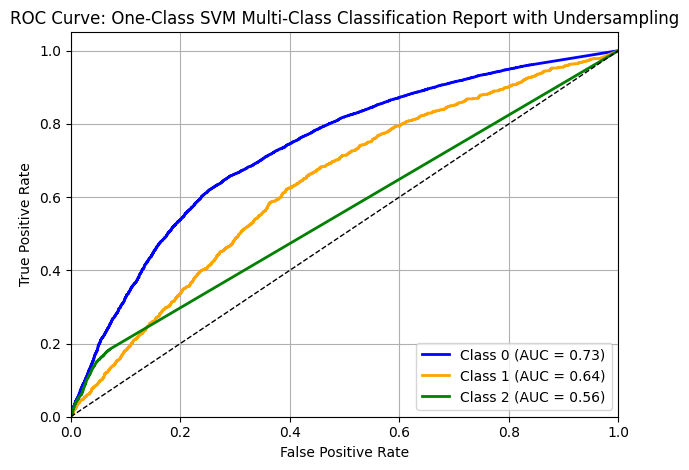

In [14]:
# Get decision function scores for all classes
decision_scores = []

for idx in range(X_test.shape[0]):
    sample = X_test.iloc[idx:idx+1]
    score_0 = ocsvm_0.decision_function(sample)[0]
    score_1 = ocsvm_1.decision_function(sample)[0]
    score_2 = ocsvm_2.decision_function(sample)[0]
    decision_scores.append([score_0, score_1, score_2])

y_score = np.array(decision_scores)

# Normalize scores to [0, 1] range for ROC use
y_score = (y_score - y_score.min(axis=1, keepdims=True)) / (y_score.max(axis=1, keepdims=True) - y_score.min(axis=1, keepdims=True) + 1e-8)

# Binarize y_test
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Plot all ROC classes
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0', 'Class 1', 'Class 2']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: One-Class SVM Multi-Class Classification Report with Undersampling")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

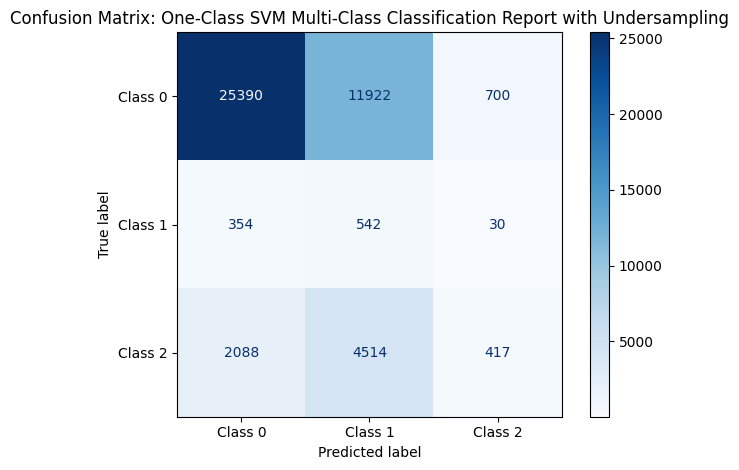

In [15]:
cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: One-Class SVM Multi-Class Classification Report with Undersampling")
plt.grid(False)
plt.tight_layout()
plt.show()